In [168]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn import metrics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [103]:
corona = pd.read_csv('clean_covid.csv')

# Feature engineering  
In this section we want to transform our data so that it can be ready to be fed to the model that we will be creating next.
This involves a couple of things:
1. Encoding our data
2. Feature selection - determining the important columns that we will be using in our models
3. Splitting our data to the train and test data

### Encode our data set

In [104]:
encoder = LabelEncoder()

In [105]:
for col in corona.columns:
    if corona[col].dtype=='O':
        corona[col] = encoder.fit_transform(corona[col])

In [106]:
corona.head(10)

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,23,1,0,0,0,0,0,1,1,2
1,23,1,0,0,0,0,1,0,0,2
2,23,0,0,0,0,0,0,0,0,2
3,23,0,1,0,0,0,0,0,0,0
4,23,1,0,0,0,0,0,1,0,2
5,23,0,0,0,0,0,1,0,1,2
6,23,0,0,0,0,0,0,0,0,0
7,23,1,0,0,0,0,1,0,0,1
8,23,0,0,0,0,0,0,0,1,2
9,23,1,1,1,0,0,0,0,1,1


In [165]:
## save the dataset for use in data visualization
corona.to_csv('clean_transformed_data.csv', index=False)

### Select the most relevant feature columns to be used in our models
For this we will use SelectKBest method that will rank our feature columns from the highest score to lowest.
We will also use a heatmap to look at the correlation between our columns for selection putposes

In [107]:
X = corona.drop(['corona_result', 'test_date'], axis=1)
y = corona['corona_result']

In [108]:
# the chi square is our score function that will run the algorithm to determine the score of each column
X_new = SelectKBest(chi2, k=6).fit(X, y)

In [109]:
feature_scores = pd.DataFrame()

In [110]:
feature_scores['Specs'] = X.columns
feature_scores['Score'] = X_new.scores_

In [111]:
feature_scores.sort_values(by='Score', ascending=False)

,Specs,Score
4,head_ache,292.096801
2,sore_throat,163.779846
3,shortness_of_breath,159.059041
5,age_60_and_above,22.978262
7,test_indication,22.082242
1,fever,5.231585
0,cough,1.065263
6,gender,0.812724


In [112]:
## gender, test_date and possibly cough have scored the lowest thus might be omitted as one of the feature columns

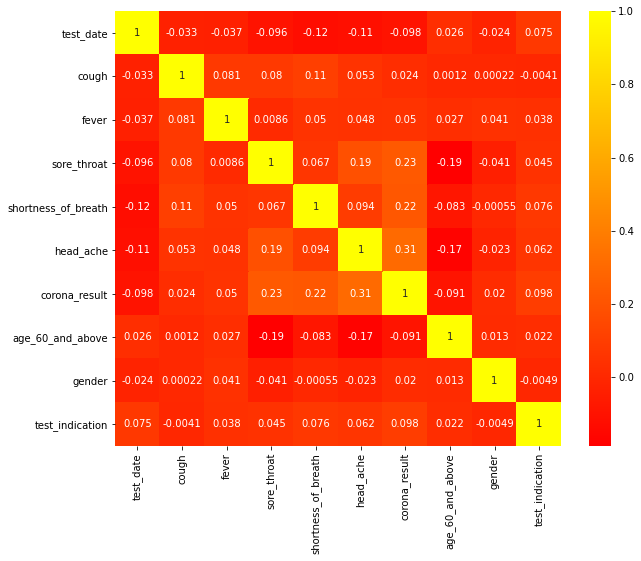

In [169]:
### Checking for correlations
corr = corona.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='autumn')
plt.show()

### Handling Imbalanced data
In this section we will check on imbalancement in our label or target data. We do this to minimize overfitting or underfitting of our model. Our label data is said to be imbalanced if suppose it has a factor level 2(two values), if the ratio of appearance of the first value is 95% or more than the other value, then there is an imbalance.

In [113]:
y.value_counts()

1    2893
0    1285
Name: corona_result, dtype: int64

In [114]:
ratio_0 = 100 * (y.value_counts()[0]/y.shape[0])

In [115]:
ratio_0

30.756342747726183

In [116]:
## THE ration of 0 and 1 is 3 to 7 respectively so our target variable data is not imbalanced

### Splitting our data to training and testing sets
For this we have to split our data into training data and testing data. In training data we have the training feature data or x_train and training label data or y_train. Same goes for testing data

In [117]:
X = corona.drop(['corona_result', 'test_date', 'gender', 'cough'], axis=1)
y = corona['corona_result']

In [118]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.25)

### Training our data
We can start by creating our machine learning model and use the x and y trains to train our data while the testing data we will use to test our models and get accuracy

In [119]:
## create a pipeline for constructing our model and use the standard scaler
def training_model(model):
    pipe = make_pipeline(StandardScaler(), model)
    pipe.fit(x_train, y_train)
    return pipe

In [120]:
lr_model = training_model(LogisticRegression())
svc_model = training_model(SVC())

#### Training Decision Tree and Random forest model by tweaking there parameter
For this two models, I would like to train it in a different way so that I can tweak the parameters inside it to find optimum number of trees or/and nodes for these models. We can use the GridSearch to get the best parameter values

In [121]:
rfc = RandomForestClassifier()
dtc = DecisionTreeClassifier()

In [122]:
def best_params():
    rfc_params = {
        'n_estimators': [2, 5, 10, 50],
        'min_samples_split': [1,2,3,5],
        'min_samples_leaf': [1,2,3,5],
        'max_features': ['auto', 'sqrt', 'log2']
    #     'max_depth' : [4,5,6,7,8],
    }
    CV_rfc = GridSearchCV(estimator=rfc, param_grid=rfc_params, cv=5)
    CV_rfc.fit(x_train, y_train)
    return CV_rfc.best_params_

In [123]:
{'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 2}

{'max_features': 'log2',
 'min_samples_leaf': 5,
 'min_samples_split': 3,
 'n_estimators': 2}

In [ ]:
# print out the best params to use for the random Forest
print(best_params())

In [124]:
# Training our model
rfc_model = training_model(RandomForestClassifier(n_estimators=2, min_samples_split=3, min_samples_leaf=5, max_features='log2'))

In [125]:
dt = DecisionTreeClassifier()

In [126]:
def dt_best_param():
    dt_params = {
        'min_samples_split': [1,2,3,5,10],
        'max_leaf_nodes': [2,3,5,10,20,50],
        'min_samples_leaf': [1,2,3,5,10]
    }
    CV_dt = GridSearchCV(estimator=dt, param_grid=dt_params, cv=5)
    CV_dt.fit(x_train, y_train)
    return CV_dt.best_params_

In [ ]:
print(dt_best_param())

In [127]:
dt_model = training_model(RandomForestClassifier(max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2))

### Let's test out our model to see it's accuracy
We will also use the accuracy score as well as classification_report to get the entire report on each score

In [128]:
## test your model using the testing model function
def testing_model(model):
    y_pred = model.predict(x_test)
    score = metrics.accuracy_score(y_test, y_pred)
    report = metrics.classification_report(y_test, y_pred)
    return [score, report]

In [129]:
# Let's print out the accuracy for each model created
print(f'logistic regression: {testing_model(lr_model)[0]}')
print(f'random forest: {testing_model(rfc_model)[0]}')
print(f'decision tree: {testing_model(dt_model)[0]}')
print(f'support vector classifier: {testing_model(svc_model)[0]}')


logistic regression: 0.7081339712918661
random forest: 0.7033492822966507
decision tree: 0.707177033492823
support vector classifier: 0.6995215311004784


In [130]:
# report on logistic regression model
print(testing_model(lr_model)[1])

              precision    recall  f1-score   support

           0       0.56      0.41      0.47       336
           1       0.75      0.85      0.80       709

    accuracy                           0.71      1045
   macro avg       0.66      0.63      0.64      1045
weighted avg       0.69      0.71      0.69      1045



In [131]:
# report on random forest model
print(testing_model(rfc_model)[1])

              precision    recall  f1-score   support

           0       0.54      0.57      0.55       336
           1       0.79      0.77      0.78       709

    accuracy                           0.70      1045
   macro avg       0.66      0.67      0.66      1045
weighted avg       0.71      0.70      0.71      1045



In [132]:
# report on decision tree model
print(testing_model(dt_model)[1])

              precision    recall  f1-score   support

           0       0.60      0.27      0.37       336
           1       0.73      0.92      0.81       709

    accuracy                           0.71      1045
   macro avg       0.66      0.59      0.59      1045
weighted avg       0.68      0.71      0.67      1045



### Saving our model as .pkl extension using pickle

In [134]:
## saving model inside the pickle module
import pickle
pickle.dump(_model, open('rfc_model.pkl', 'wb'))

In [140]:
model = pickle.load(open('rfc_model.pkl', 'rb'))

In [161]:
# pred_col = list(pred_df.columns.values)
result = model.predict([[1, 0, 0, 0, 0, 2]])

In [162]:
result

array([0], dtype=int64)